# Exercise 1

The submission deadline is **04.11.2024 23:55.**

## Task Description

The goal of this exercise is to model the relationship between weather observations and the occurence of traffic disruptions in the city of Vienna.

To investigate a potential relationship, we will use two datasets:
 * tri-daily weather reports from 2009 - 2023 of Vienna.
 * reports on traffic disruptions in Vienna ffrom 2013 - 2023.

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually analyse data,
 * use `scikit-learn` to build prediction models.

The data to be used can be found in: `HOME/shared/188.995-2024W/data/`. 

To complete this exercise, you will have to:
* prepare the data, which (at minimum) involves the following:
    - load and prepare the data
    - handling missing values
    - handling outliers
    - temporal alignment of the two datasets
* analyse the data:
    - compare descriptive statistics
    - visually investigate the raw data to gain an understanding of the data identify patterns, outliers etc.,
    - look at the relationship between the variables of interest
* model the relationship:
    - fit a model that classifies new traffic disruptions from weather observation data
    
    
**Note:** In case you encounter problems with loading and processing the data (tasks 1-5), we will provide you also with a pickled version of a preprocessed and merged datasets that you can use to complete the remaining parts of the exercise (tasks 6-8).

There is a total of 100 points that can be reached which are distributed in two notebooks in the following way:

Notebook A (this notebook), total 55 points:
 - Task 1: 20 points
 - Task 2: 15 points
 - Task 3: 10 points
 - Task 4: 5 points
 - Task 5: 5 points


 Notebook B, total 45 points:
 - Task 6: 15 points
 - Task 7: 20 points
 - Task 8: 10 points

In [99]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing


## Task 1: Load Data (20 Points)

### 1.1: Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) datasets from the csv files in `data/weather/` into a single `pd.DataFrame` and return it. 

- make sure that you load all the data (2009-2023, 15 years)
- split the tri-daily and daily data (tri-daily data has _7h, _14h, and _19h suffixes for column headers), and convert the tri-daily data from a wide to a long format (use pandas' [wide_to_long](https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html) or [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt) functions). Introduce a new `hours` column which's values should be taken from the column suffixes.
- make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!
- from the `date` column create `year`, `month`, `day` columns. Use Pandas built-in datetime handling features.
- from the wide to long transform, you should have an `hour` column with the 7, 14, or 19 hours values.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `day` - `hour` (make sure to label them accordingly)

**Hints:**
 
 - LOOK at the data in the original files and their descriptions
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Note that for the `precip` data column you will get an unexpected (object) datatype. For this task it is ok to leave it like that, it is due to special values, see next chapters!
 - Your resulting data frame should look as follows, with temperature in Celsius, air pressure in hecto Pascal, skyCover on a scale from 1-10, humidity in percent, windDir in compass directions, windBeauf in Beaufort and precip in millimeters.:
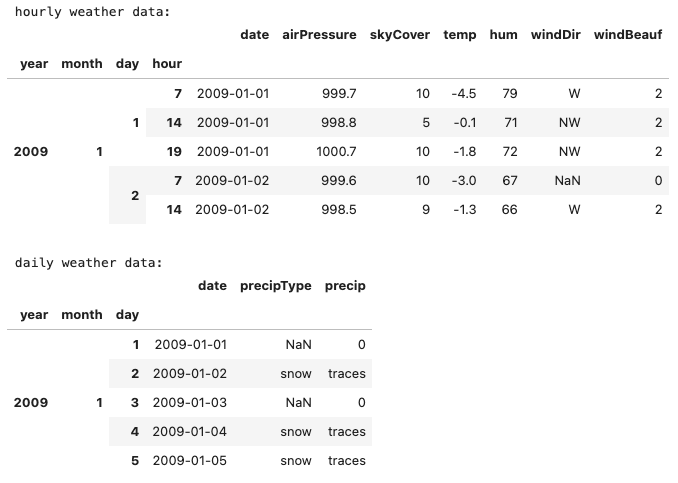

In [100]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_path = os.path.join(os.environ["HOME"], "shared", "188.995-2024W", "data")
weather_data_path = os.path.join(data_path, 'weather')
traffic_data_path = os.path.join(data_path, 'traffic')

In [101]:
def load_weather_data(weather_data_path: str) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data create a new hour column using the indicated hour in the column names.
    Add a hierarchical index (year, month, day, hour).
    For the daily-only data also add a hierarchical index (year, month, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hours) weather data
    weather_data_daily: data frame containing the daily weather data (e.g. precip, precipType, etc.)
    """

    # merge all csv files
    paths = glob.glob(weather_data_path + '/*.csv')
    dfs = [pd.read_csv(path, sep=';') for path in paths]
    merged = pd.concat(dfs, ignore_index=True)

    dfs = []
    for path in paths:
        df = pd.read_csv(path, sep=';')
        
        if '2023' in path:  # convert fahrenheit (see description file)
            print(path)
            temp_columns = [col for col in df.columns if col.startswith('temp_')]
            for col in temp_columns:
                df[col] = (df[col] - 32) * 5/9
        
        dfs.append(df)
    merged = pd.concat(dfs, ignore_index=True)

    # parse date col
    merged['date'] = pd.to_datetime(merged['date'], format='%d.%m.%Y')
    merged['year'] = merged['date'].dt.year
    merged['month'] = merged['date'].dt.month
    merged['day'] = merged['date'].dt.day

    # weather_data
    tri_daily_columns = [col for col in merged.columns if col.endswith(('_7h', '_14h', '_19h'))]
    tri_daily_data = merged[['year', 'month', 'day', 'date'] + tri_daily_columns]
    tri_daily_long = pd.wide_to_long(tri_daily_data, stubnames=['airPressure', 'skyCover', 'temp', 'hum', 'windDir', 'windBeauf'], i=['year', 'month', 'day', 'date'], j='hour', sep='_', suffix='\d+h').reset_index()
    tri_daily_long['hour'] = tri_daily_long['hour'].str.replace('h', '').astype(int)
    for col in ['airPressure', 'skyCover', 'temp', 'hum', 'windBeauf']:
        tri_daily_long[col] = pd.to_numeric(tri_daily_long[col], errors='coerce')
    weather_data = tri_daily_long.set_index(['year', 'month', 'day', 'hour']) # multiindex
    weather_data = weather_data.sort_index()

    # weather_data_daily
    weather_data_daily = merged[['year', 'month', 'day', 'date', 'precipType', 'precip']] # set order
    weather_data_daily = weather_data_daily.set_index(['year', 'month', 'day', 'date'])
    weather_data_daily = weather_data_daily.sort_index()

    return weather_data, weather_data_daily

In [102]:
# DO NOT MODIFY OR COPY THIS CELL!! 
weather_data, daily_weather_data = load_weather_data(weather_data_path)
# print first couple of rows:
print('hourly weather data:')
display(weather_data.head())
print('\ndaily weather data:')
display(daily_weather_data.head())

/home/e11912007/shared/188.995-2024W/data/weather/weather_daily_2023.csv
hourly weather data:


date  airPressure  skyCover  temp  hum windDir  \
year month day hour                                                        
2009 1     1   7    2009-01-01        999.7        10  -4.5   79       W   
               14   2009-01-01        998.8         5  -0.1   71      NW   
               19   2009-01-01       1000.7        10  -1.8   72      NW   
           2   7    2009-01-02        999.6        10  -3.0   67     NaN   
               14   2009-01-02        998.5         9  -1.3   66       W   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2


daily weather data:


precipType  precip
year month day date                         
2009 1     1   2009-01-01        NaN       0
           2   2009-01-02       snow  traces
           3   2009-01-03        NaN       0
           4   2009-01-04       snow  traces
           5   2009-01-05       snow  traces

In [103]:
# use this cell to inspect the data.

print(f"Data dimensions are: {weather_data.shape[0]} rows and {weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{weather_data.dtypes}")

print(f"\nFor daily data: \nData dimensions are: {daily_weather_data.shape[0]} rows and {daily_weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{daily_weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{daily_weather_data.dtypes}")


Data dimensions are: 16434 rows and 7 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
hour     int64
dtype: object

column types are: 
-----------------
date           datetime64[ns]
airPressure           float64
skyCover                int64
temp                  float64
hum                     int64
windDir                object
windBeauf               int64
dtype: object

For daily data: 
Data dimensions are: 5478 rows and 2 columns

index types are: 
-----------------
year              int32
month             int32
day               int32
date     datetime64[ns]
dtype: object

column types are: 
-----------------
precipType    object
precip        object
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will be automatically assigned by the hidden test, try to make sure that you covered all required points from above!

In [104]:
# use this cell to create your own tests. best case: create a test for each requirement above!
# Note: you can add new cells also for the other tasks to add your own tests. 
# But NEVER COPY an existing cell, since this can break the autograding!

In [105]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# TESTS: dimensions should be like this:
assert weather_data.shape[0] == 16434 # 5478
assert weather_data.shape[1] >= 7 # 24

In [106]:
# hidden tests for grading DO NOT MODIFY OR COPY THIS CELL!!

In [107]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

In [108]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

#### Question
In which month was the average temperature the lowest?
- Implement the function below to find the answer!
- Find the respective entry/entries using pandas!!

In [109]:
def get_lowest_average_temp(data_frame: pd.DataFrame):
    year, month = data_frame.groupby(["year", "month"])["temp"].mean().idxmin()
    return year, month

In [110]:
# DO NOT MODIFY OR COPY THIS CELL!!
low_num_year, low_num_month = get_lowest_average_temp(weather_data)
print(f"Month {low_num_month}, of year {low_num_year} has the lowest average temperature!")

Month 1, of year 2017 has the lowest average temperature!


In [111]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 1.2: Traffic disruptions

Load and prepare the second dataset (`HOME/shared/188.995-2024W/data/traffic/traffic_disruptions.csv`), which contains all traffic disruptions for each day. 
- Create a dataset based on the provided file
- For each entry extract the year, month and day
- Create a `MultiIndex` from the `year` and `month` and `day` columns (it is allowed to have duplicates here). Hint: convert the `date` column to `pandas` datetime to later extract the indices from it. 
- Make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!

- Create a `disruption` column that contains the different types of disruptions. For this, you can filter the `Titel` column from the original data set using a regex.
  Hint: Search for a whitespace followed by 4 or more characters and also account for the rest of the disruption name. "Badner Bahn" line will raise issues, so find a way to work around that.
  Note that the end solution should not contain whitespaces.

- Use the `Linie(n)` column to create three new columns called `bus`, `subway` and `tram`, which are boolean indicators, telling you whether this type was involved in the incident.
    * A bus was involved if the line contains two digits followed by either an 'A' or 'B'
    * A subway line was involved if it contains a 'U' followed by a number from 1 to 6, which is not followed by a 'Z' or 'z'
    * A tram line was involved if it matches specific named lines like D, O, U2Z/U2z, VRT, WLB, Badner Bahn, or any single- or double-digit number that is not followed by a letter

- Add the duration of an incident by using `Start` and `Ende`
- Delete all original columns of the dataset
- Remove all NaN values and also all values that contain `Test` in the `disruption` column
- You will find similar names, in the disruption column, you are free to combine them to reduce the number of different disruptions.
- Your resulting data frame should look as follows:
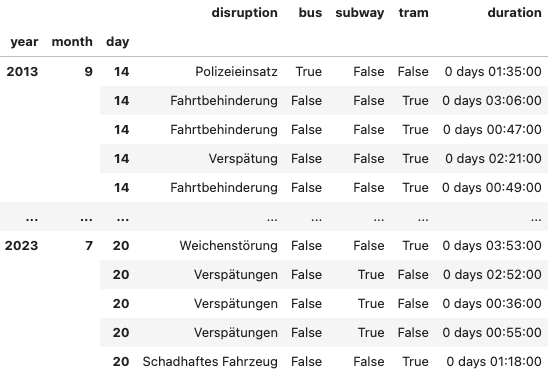


In [112]:
def load_traffic_data() -> pd.DataFrame:
    """ 
    Load the traffic data from the files into a pndas dataframe
    
    Returns
    --------
    traffic_data: data frame containing the traffic data
    """
    import re

    path = glob.glob(traffic_data_path + '/*.csv')[0]
    traffic = pd.read_csv(path, sep=';')

    # parse date col
    traffic['Start'] = pd.to_datetime(traffic['Start'], format='%d.%m.%Y %H:%M', errors='coerce')
    traffic['Ende'] = pd.to_datetime(traffic['Ende'], format='%d.%m.%Y %H:%M', errors='coerce')
    traffic['year'] = traffic['Start'].dt.year
    traffic['month'] = traffic['Start'].dt.month
    traffic['day'] = traffic['Start'].dt.day
    traffic.set_index(['year', 'month', 'day'], inplace=True)
    traffic['duration'] = (traffic['Ende'] - traffic['Start']).fillna(pd.Timedelta(seconds=0))

    # extract disruption values
    def extract_disruption(title):
        if isinstance(title, str):
            title = title.strip()
            title = re.sub(r'\s*,\s*', ',', title) # drop whitespace before and after ","
            title = re.sub(r'\s*:', ':', title) # drop whitespace before ":"
            title = ' '.join([elem for elem in title.split() if elem.isalpha()]) # drop non alphanumeric chars
            
            fst_word = title.split()[0] if len(title) > 0 else "" # drop first word if too short
            if len(fst_word) <= 4:
                title = ' '.join(title.split()[1:])
            
            if title.count(':') == 1: # get stuff after first colon
                title = title.split(':')[1].strip()

            is_timestamp = title.count('.') >= 3
            is_nan = title.strip().lower() == "nan"
            is_test = "test" in title.lower()
            too_short = len(title) <= 4
            if not (is_timestamp or is_nan or is_test or too_short):
                return title
        return "unknown"
    traffic['disruption'] = traffic['Titel'].apply(extract_disruption)
    
    # merge similar values
    # traffic['disruption'] = traffic['disruption'].replace({
    #     'Fahrtbehinderung': 'Fahrbehinderung',
    #     'Verspätungen': 'Verspätung',
    #     'Verkehrsbedingte Verspätung Verspätungen': 'Verkehrsbedingte Verspätungen',
    #     'Verkehrsbedingt Verspätungen': 'Verkehrsbedingte Verspätungen',
    #     'Verkehrsstörung Verspätungen': 'Verkehrsbedingte Verspätungen',
    #     'Verkehrsbedingt': 'Verkehrsbedingte Verspätungen',
    #     'Fremder Verkehrsunfall': 'Verkehrsunfall',
    #     'Regenbogenparade Verspätungen': 'Veranstaltung',
    #     'Schadhaftes Fahrzeug Verspätungen': 'Schadhaftes Fahrzeug',
    # })

    # drop unknowns
    traffic = traffic[traffic['disruption'] != "unknown"] # drop unknown values
    traffic = traffic.dropna()

    # extract lines
    traffic['bus'] = traffic['Linie(n)'].str.contains(r'\d{2}[AB]', na=False).astype(bool)
    traffic['subway'] = traffic['Linie(n)'].str.contains(r'U[1-6](?![Zz])', na=False).astype(bool)
    # traffic['tram'] = traffic['Linie(n)'].str.contains(r'(D|O|U2[Zz]|VRT|WLB|Badner Bahn|\d{1,2}(?![A-Za-z]))')
    traffic['tram'] = (~traffic['bus']) & (~traffic['subway']).astype(bool) # others are false
    
    # select columns
    traffic = traffic[["disruption", "bus", "subway", "tram", "duration"]]
    traffic = traffic.sort_index()
    return traffic

In [113]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_traffic = load_traffic_data()
display(data_traffic)



disruption    bus  subway   tram        duration
year month day                                                            
2013 9     14         Polizeieinsatz   True   False  False 0 days 01:35:00
           14       Fahrtbehinderung  False   False   True 0 days 03:06:00
           14       Fahrtbehinderung  False   False   True 0 days 00:47:00
           14             Verspätung  False   False   True 0 days 02:21:00
           14       Fahrtbehinderung  False   False   True 0 days 00:49:00
...                              ...    ...     ...    ...             ...
2023 7     20         Weichenstörung  False   False   True 0 days 03:53:00
           20           Verspätungen  False    True  False 0 days 02:52:00
           20           Verspätungen  False    True  False 0 days 00:36:00
           20           Verspätungen  False    True  False 0 days 00:55:00
           20   Schadhaftes Fahrzeug  False   False   True 0 days 01:18:00

[94656 rows x 5 columns]

In [114]:
# use this cell to inspect the data.

print(f"Data dimensions are: {data_traffic.shape[0]} rows and {data_traffic.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{data_traffic.index.dtype}")
print(f"\ncolumn types are: \n-----------------\n{data_traffic.dtypes}")

Data dimensions are: 94656 rows and 5 columns

index types are: 
-----------------
object

column types are: 
-----------------
disruption             object
bus                      bool
subway                   bool
tram                     bool
duration      timedelta64[ns]
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will automatically be assigned by the hidden test, try to make sure that you covered all required points from above!

In [115]:
# use this cell to create your own tests
data_traffic['disruption'].unique()

array(['Polizeieinsatz', 'Fahrtbehinderung', 'Verspätung',
       'Schadhaftes Fahrzeug', 'Verkehrsunfall', 'Erkrankung',
       'Gleisschaden', 'Rettungseinsatz', 'Sachbeschädigung',
       'Wagengebrechen', 'Stromstörung', 'Signalstörung',
       'Schadhafter Zug', 'Polizeieinsatz Verspätungen',
       'erhöhtes Fahrgastaufkommen Verspätungen', 'Feuerwehreinsatz',
       'Falschparker', 'Verspätungen', 'Verkehrsbedingt Verspätungen',
       'Verkehrsunfall Verspätungen', 'Verkehrsstörung',
       'Verkehrsstörung Verspätungen',
       'Schadhaftes Fahrzeug Verspätungen', 'Fremder Verkehrsunfall',
       'Veranstaltung', 'Rettungseinsatz Verspätungen', 'Demonstration',
       'Erkrankung eines Fahrgastes', 'Fahrleitungsgebrechen',
       'Fremder Verkehrsunfall Verspätungen',
       'Regenbogenparade Verspätungen', 'Signalstörung Verspätungen',
       'Verkehrsbedingte Verspätung Verspätungen',
       'Verkehrsbedingte Verspätungen', 'Verkehrsbedingt',
       'Weichenstörung', 'Erhöht

In [116]:
# tests DO NOT MODIFY THIS CELL!!
# final dimensions should be like this:
assert data_traffic.shape[0] > 94642
assert data_traffic.shape[0] < 94672
assert data_traffic.shape[1] == 5

In [117]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In [118]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


#### Question
Which combination of year+month+day shows the highest number of a given disruption for subway lines? 
- Implement the function below to return the result!
- You should find the respective entry/entries using pandas!
- Return the first answer if there is more than one combination fulfilling these criteria.

In [119]:
def get_day_with_most_subway_disruptions(data_frame: pd.DataFrame, disruption_type: str) -> typing.Tuple[int,int,int]:
    year = 0
    month = 0
    day = 0
    
    filtered_data = data_frame[(data_frame['disruption'] == disruption_type) & (data_frame['subway'])]
    
    disruption_counts = filtered_data.groupby(['year', 'month', 'day']).size().reset_index(name='counts')

    if not disruption_counts.empty:
        max_count = disruption_counts['counts'].max()
        result = disruption_counts[disruption_counts['counts'] == max_count].iloc[0] # get first
        year, month, day = result['year'], result['month'], result['day']
    
    return year, month, day

In [120]:
# DO NOT MODIFY OR COPY THIS CELL!! 
year, month, day =get_day_with_most_subway_disruptions(data_traffic, 'Schadhaftes Fahrzeug')
print(f"{day}.{month}.{year} has the highest number of malfunctioning subway lines!")

7.7.2023 has the highest number of malfunctioning subway lines!


In [121]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


## Task 2: Handling Missing Values (15 Points)

If you take a closer look at the data, you will notice that a few of the observations are missing.

There is a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is essential to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 
 

_______

You talked to the meteorologists who compiled the data to find out more about what mechanisms may have caused the missing values: 

1. They told you that they do not know why some of the temperature (`temp`) and pressure (`airPressure`) readings are missing. They suspect a problem with the IT infrastructure. In any case, the propensity of temperature and pressure values to be missing does not have anything to do with the weather itself.

2. For wind intensity values of 0, the wind direction is not provided (for obvious reasons). 

Check the plausibility of these hypotheses in the data, consider the implications, and devise appropriate strategies to deal with the various missing values.

- Handle missing values for the following columns: `temp`, `airPressure`, `windDir`

To implement your strategy, you can use a range of standard mechanisms provided by Pandas.

#### Visualize some data
Plot temperature (temp) and air pressure (airPressure) as a function of time for the weather data.
Additionally plot the average monthly sky coverage over all years.

/home/e11912007/shared/188.995-2024W/data/weather/weather_daily_2023.csv


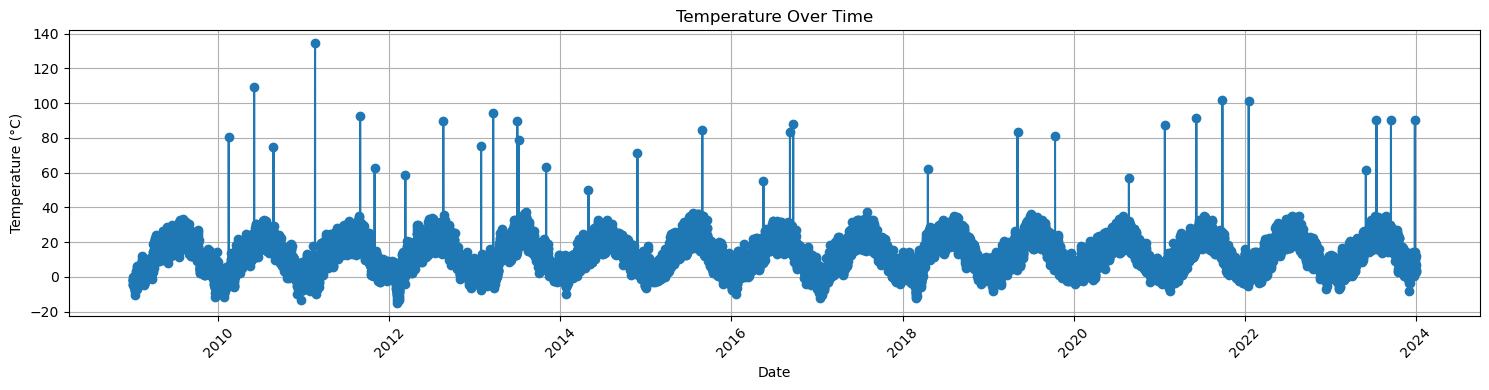

In [122]:
# plot the temperature 

weather_data, daily_weather_data = load_weather_data(weather_data_path)

temps = weather_data['temp']
dates = [datetime.datetime(year, month, day, hour) for year, month, day, hour in temps.index]

plt.figure(figsize=(15, 4))
plt.plot(dates, temps, marker='o')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

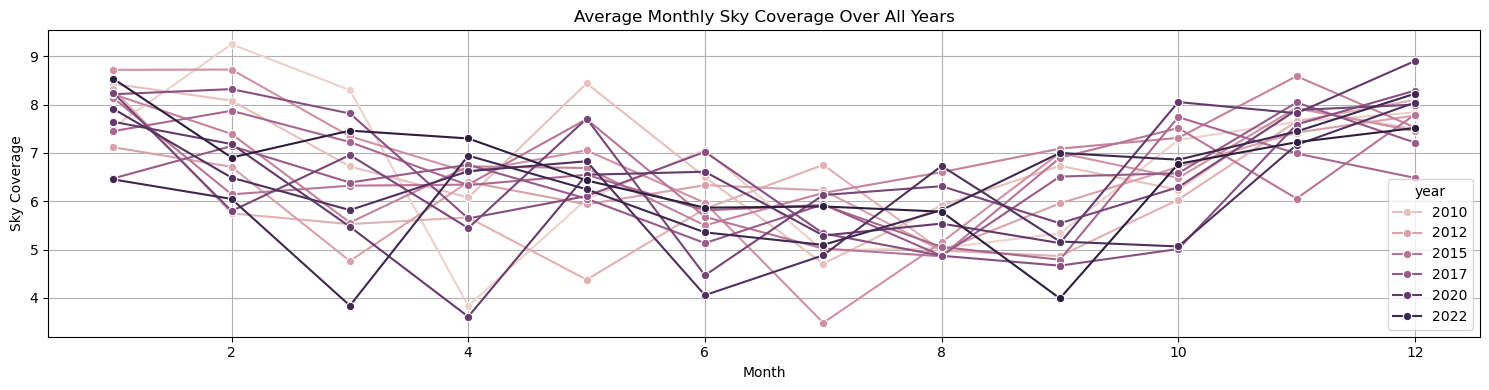

In [123]:
# plot the air pressure 

pressure = weather_data['airPressure']
df = weather_data.groupby(['year', 'month'])['skyCover'].mean().reset_index()

plt.figure(figsize=(15, 4))
sns.lineplot(data=df, x='month', y='skyCover', hue='year', marker='o')
plt.title('Average Monthly Sky Coverage Over All Years')
plt.xlabel('Month')
plt.ylabel('Sky Coverage')
plt.grid(True)
plt.tight_layout()
plt.show()

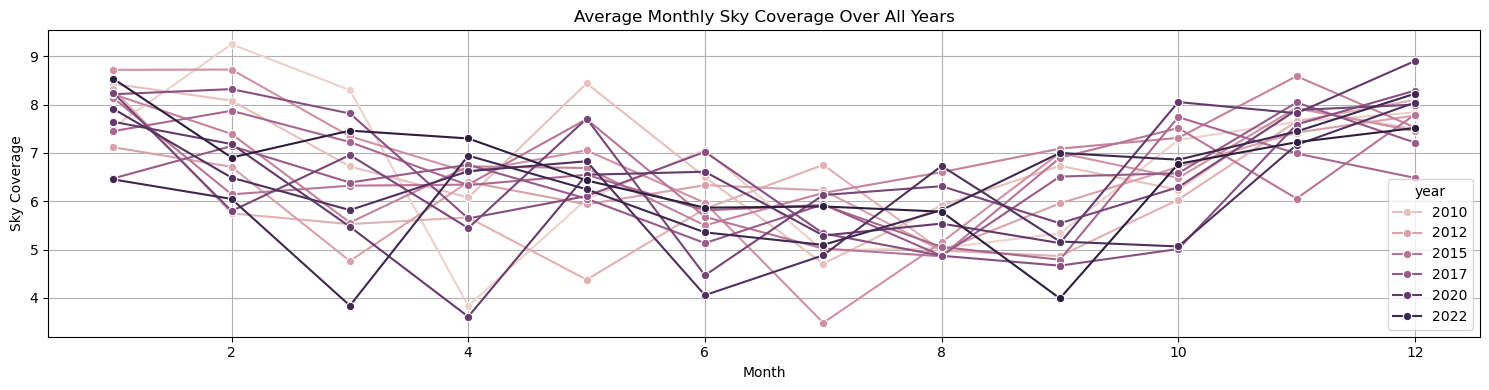

In [124]:
# plot the sky coverage 

pressure = weather_data['airPressure']
df = weather_data.groupby(['year', 'month'])['skyCover'].mean().reset_index()

plt.figure(figsize=(15, 4))
sns.lineplot(data=df, x='month', y='skyCover', hue='year', marker='o')
plt.title('Average Monthly Sky Coverage Over All Years')
plt.xlabel('Month')
plt.ylabel('Sky Coverage')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.1: Missing values for temperature and air pressure
Find and visualize missing values for `temp` and `airPressure` columns in the `weather_data` data frame.


#### Data inspection
First, let's visualize the missing data to get a better feel for what is happening.
- Implement the `get_data_around_missing` function below to extract and return a dataframe that only contains rows around missing (`isna`, `isnull`) values for the column indicated by `column`.
- First find missing values in the specified column
- For each missing value, create a dataframe that contain only rows with a date +- `delta_days` from the date of the missing value.
- Put the dataframes into `df_list` and return them.

In [125]:
def get_data_around_missing(df:pd.DataFrame, column:str, delta_days:int=2) -> typing.List[pd.DataFrame]:
    """ 
    Build a list of dataframes containing missing values indicated by column. 
    Each dataframe contains rows around a missing (isna)
    value in column, within a date of +- delta_days.

    Parameters
    --------
    df: dataframe containing the missing values
    column: the column to look for missing values
    delta_days: the number of days +-around the date of the missing values to keep in the returned data frames
    
    Returns
    --------
    df_list: list of dataframes with some missing data
    """
    df_list = []
    
    # use date as index again
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
    
    # find missing vals in chosen col
    missing_dates = df[df[column].isna()].index 
    
    for date in missing_dates:
        start_date = date - pd.Timedelta(days=delta_days)
        end_date = date + pd.Timedelta(days=delta_days)        
        df_subset = df.loc[start_date:end_date]
        df_list.append(df_subset)
    
    return df_list

In [126]:
# DO NOT MODIFY OR COPY THIS CELL!! 
missing_temp_df_list = get_data_around_missing(weather_data, 'temp')
missing_airPressure_df_list = get_data_around_missing(weather_data, 'airPressure')

In [127]:
# tests, DO NOT MODIFY OR COPY THIS CELL!! 
print(len(missing_temp_df_list))
print(len(missing_airPressure_df_list))

assert 300 < len(missing_temp_df_list) < 400, "There should be between 300 and 400 missing values in temp!"
assert 300 < len(missing_airPressure_df_list) < 400, "There should be between 300 and 400 missing values in airPressure!"

assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_temp_df_list])
assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_airPressure_df_list])

336
319


In [128]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In order to be able to see the data, complete the function `plot_value_series` to plot a timeseries of a dataframe identified by `column`:


In [129]:
def plot_value_series(df:pd.DataFrame, column:str) -> None:
    """ 
    Plot the values in column in data frame df
    """
    vals = weather_data[column]
    dates = [datetime.datetime(year, month, day, hour) for year, month, day, hour in temps.index]

    plt.figure(figsize=(15, 4))
    plt.plot(dates, vals, marker='o')
    plt.title(f'Time Series of {column}')
    plt.xlabel('Date')
    plt.ylabel(f'{column}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Now we use the function to plot a missing value for `temp` and `airPressure`:

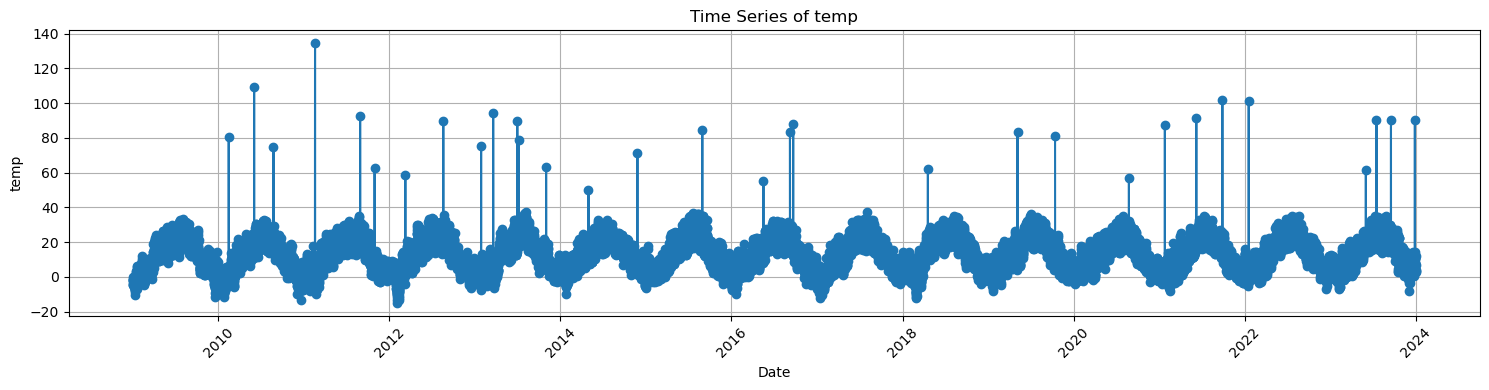

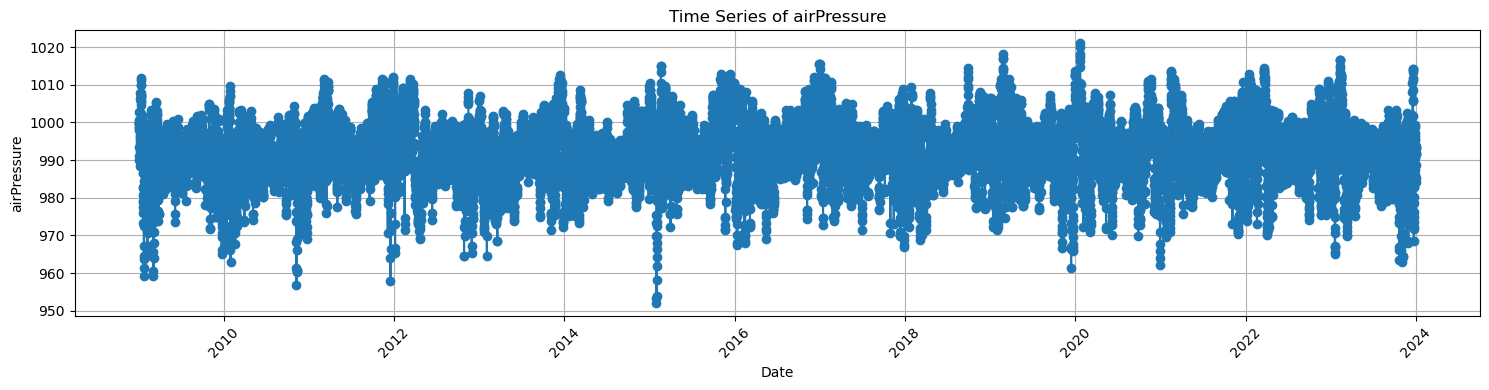

In [130]:
# tests,  DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[0], 'temp')
plot_value_series(missing_airPressure_df_list[0], 'airPressure')

In [131]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

#### Handle missing temperature values
Use the plots above and the information that was given to us by the meterologist to decide on a suitable strategy to fix the missing values.

- Implement the function below to get rid of the missing values for temperature (`temp`).
- Choose an appropriate strategy to fill in the misssing values.

In [132]:
def handle_missing_temp_values(df:pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing temperature values appropriately!

    Parameters
    --------
    df: dataframe containing the missing values
    
    Returns
    --------
    df_ret: dataframe with fixed values
    """
    # something simple since values are suspected to be Missing Completely At Random (MCAR) due to IT infrastructure issues.
    df_ret = df.copy()
    df_ret['temp'] = df_ret['temp'].interpolate(method='linear') # linear interpolation
    return df_ret

Plot the fixed stretch of temp values from above, and compare to the unmodified version:

In [133]:
missing_temp_idx = 0

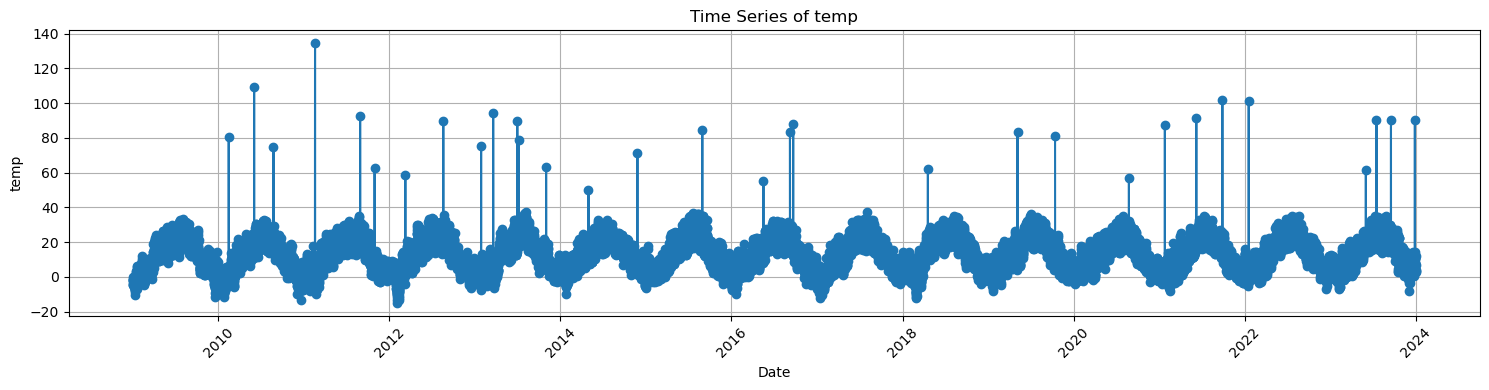

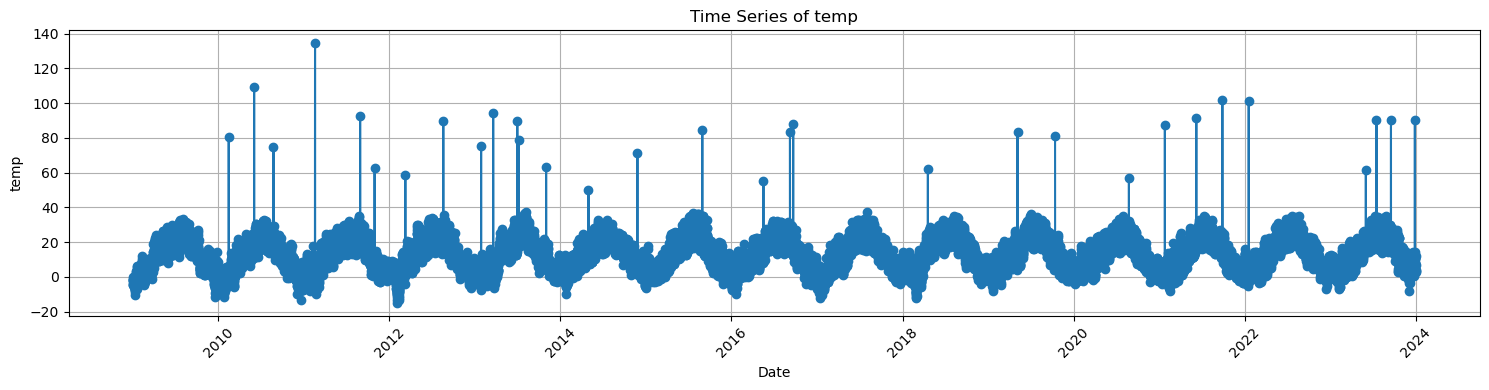

In [134]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[missing_temp_idx], 'temp')
plot_value_series(handle_missing_temp_values(missing_temp_df_list[missing_temp_idx]), 'temp')

#### Handle missing air pressure values

Do the same for the air pressure values:

- Implement the function below to get rid of the missing values for air pressure (`airPressure`).
- Choose an appropriate strategy to fill in the misssing values.

In [135]:
def handle_missing_airPressure_values(df:pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing air pressure values appropriately!

    Parameters
    --------
    df: dataframe containing the missing values
    
    Returns
    --------
    df_ret: dataframe with fixed values
    """
    # something simple since values are suspected to be Missing Completely At Random (MCAR) due to IT infrastructure issues.
    df_ret = df.copy()
    df_ret['airPressure'] = df_ret['airPressure'].interpolate(method='linear')
    return df_ret

Plot the fixed stretch of airPressure values from above:

In [136]:
missing_apr_idx = 0

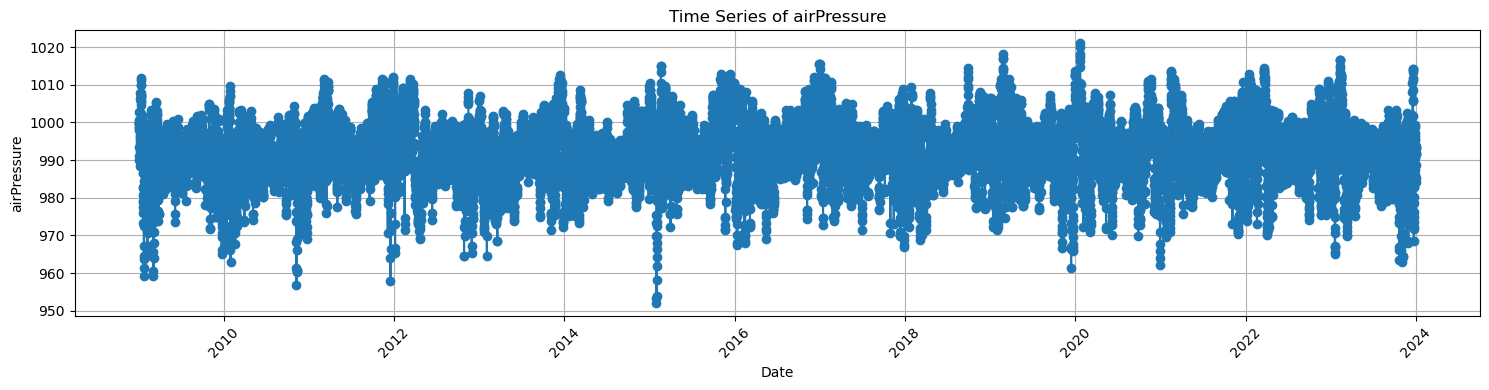

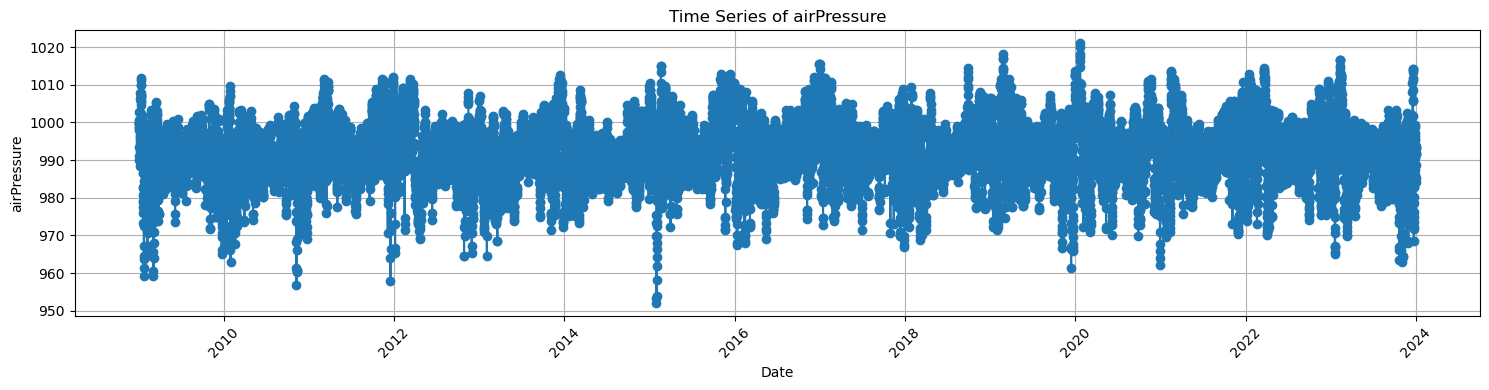

In [137]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_airPressure_df_list[missing_apr_idx], 'airPressure')
plot_value_series(handle_missing_airPressure_values(missing_airPressure_df_list[missing_apr_idx]), 'airPressure')

In [138]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# the function to get the short dataframes around missing values should now return an empty list if we fix all temp values!
empty_temp_list = get_data_around_missing(handle_missing_temp_values(weather_data), 'temp')
empty_airPressure_list = get_data_around_missing(handle_missing_airPressure_values(weather_data), 'airPressure')
assert len(empty_temp_list) == 0
assert len(empty_airPressure_list) == 0

In [139]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.2 Missing wind direction values

#### Data inspection
Check the assumption for missing wind direction values and handle the missing wind direction values in an appropriate way.

/home/e11912007/shared/188.995-2024W/data/weather/weather_daily_2023.csv
missing windDir values: 1.2778386272362174%


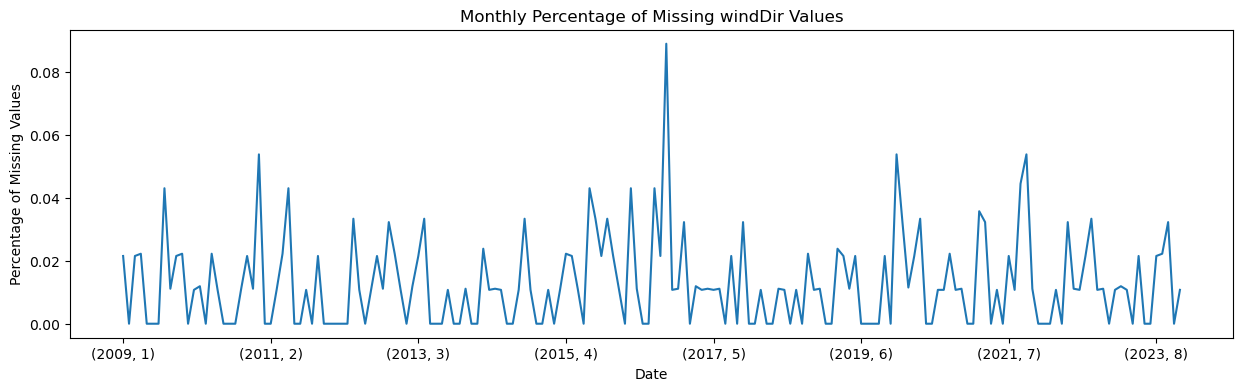

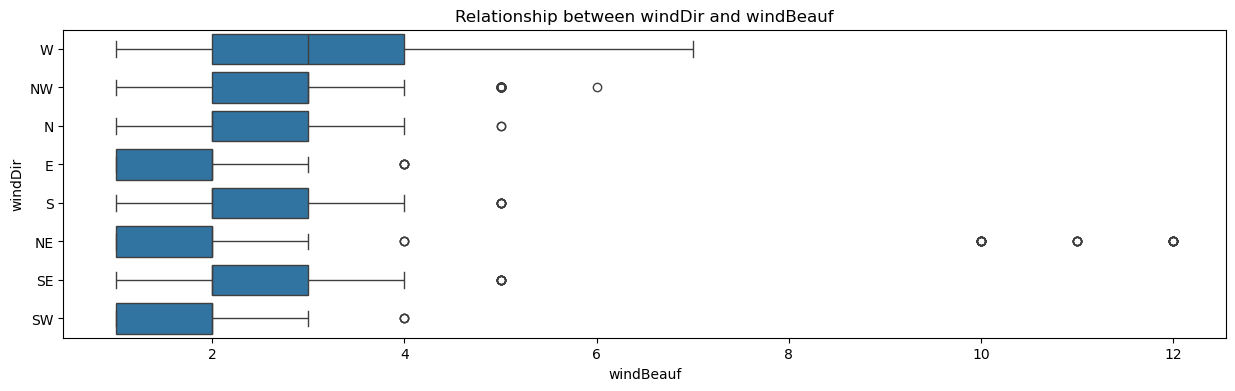

percentage of missing windDir when windBeauf is 0: 100.00%


In [140]:
# write some code to check the assumtion for missing values of windDir

weather_data, daily_weather_data = load_weather_data(weather_data_path)

def get_nan_percentage_winddir(weather_data: pd.DataFrame) -> float:
    missing_windDir = weather_data['windDir'].isna()
    missing_percentage = missing_windDir.mean() * 100
    return missing_percentage

print(f"missing windDir values: {get_nan_percentage_winddir(weather_data)}%")

# check for patterns in missing data
missing_windDir = weather_data['windDir'].isna()
weather_data['missing_windDir'] = missing_windDir
monthly_missing = weather_data.groupby(['year', 'month'])['missing_windDir'].mean()
weather_data.drop('missing_windDir', axis=1, inplace=True)
plt.figure(figsize=(15, 4))
monthly_missing.plot()
plt.title("Monthly Percentage of Missing windDir Values")
plt.ylabel("Percentage of Missing Values")
plt.xlabel("Date")
plt.show()

# check relationship between windDir and windBeauf
plt.figure(figsize=(15, 4))
sns.boxplot(x='windBeauf', y='windDir', data=weather_data)
plt.title("Relationship between windDir and windBeauf")
plt.show()

# check if windDir is missing when windBeauf is 0
missing_when_calm = weather_data[weather_data['windBeauf'] == 0]['windDir'].isna().mean()
print(f"percentage of missing windDir when windBeauf is 0: {missing_when_calm * 100:.2f}%")

#### Handle missing wind direction values
Implement a function that fixes the missing wind direction values.

In [141]:
def handle_missing_windDir_values(df:pd.DataFrame) -> pd.DataFrame:
    df_ret = df.copy()

    # entries where windBeauf is 0 (calm), set windDir to 'C' (for Calm) for consistency
    df_ret.loc[df_ret['windBeauf'] == 0, 'windDir'] = 'Calm'
    
    # for remaining NaN values, use forward fill
    df['windDir'] = df['windDir'].fillna(method='ffill')
    
    return df_ret

In [142]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Apply the windDir fix and check if any missing values remain
fix_wind_dir = handle_missing_windDir_values(weather_data)
assert fix_wind_dir[fix_wind_dir['windDir'].isnull()].empty

/tmp/ipykernel_217/4273680566.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['windDir'] = df['windDir'].fillna(method='ffill')


In [143]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.3 Combine all fixes to get clean data

In [144]:
def handle_missing_values_weather(data:pd.DataFrame) -> pd.DataFrame:
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """

    data = data.copy()
    data = handle_missing_temp_values(data)
    data = handle_missing_airPressure_values(data)
    data = handle_missing_windDir_values(data)
    return data

In [145]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_complete = handle_missing_values_weather(weather_data)

/tmp/ipykernel_217/4273680566.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['windDir'] = df['windDir'].fillna(method='ffill')


In [146]:
print(f"Before: \n---------\n{weather_data.isna().sum()}")
print(f"\nAfter: \n---------\n{weather_data_complete.isna().sum()}")

Before: 
---------
date             0
airPressure    319
skyCover         0
temp           336
hum              0
windDir          0
windBeauf        0
dtype: int64

After: 
---------
date           0
airPressure    0
skyCover       0
temp           0
hum            0
windDir        0
windBeauf      0
dtype: int64


In [147]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# check if missing values are no longer present
assert not weather_data_complete.isna().any().any()
assert weather_data_complete.shape[0] == weather_data.shape[0]
assert weather_data_complete.shape[1] == weather_data.shape[1]

## Task 3: Handling Outliers (10 Points)

Additionally to the missing values, the dataset also seems to have some strange values, that are probably outliers. 
When confronted with the data, the meterologist gave you a bit more information:


1. Sometimes the temperture readings seem to be off, without any good reason.

2. In the timespan from early May 2017 until November 2017, the wind sensor was defective: it might have displayed wrong values for winds from NE direction.

3. In the `daily_weather_data`, the precipitation column contains some non-numeric values.

4. The precipitation sensor usually produces wrong values when hail is involved.






### 3.1 Temperature outliers
First we want to take a closer look at the temperature values. Check if we can identify some obvious outliers and come up with a strategy to handle/fix them.

In order to do so you will have to:
- Plot the temperature curve over time and a histogram of temperature values to identify possible outliers
- Plot a zoomed in version of individual outliers to get a better understanding what's happening
- Devise a strategy to get rid of outliers

#### Investigation
Implement the function below to create a plot of the temperature values (`temp`) over time. Additionally create a histogram with reasonable bins to identify the outliers:

In [148]:
def plot_temp_analysis(df: pd.DataFrame) -> None:
    """
    Create two plots:
    1) Temperature values over time for the whole dataframe
    2) A histogram for temperature values. 
       Choose appropriate bins enabling you to identify outliers!

    Parameters
    --------
    df: data frame containint the temperature values (temp) with potential outlier
    """

    df.index = pd.to_datetime(df['date'])
    
    # 2) temperature values over time
    plt.figure(figsize=(15, 4))
    plt.plot(df.index, df['temp'], label='Temperature (°C)', color='blue')
    plt.title('Temperature Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 2) histogram of temperature values
    plt.figure(figsize=(15, 4))
    plt.hist(df['temp'], bins=300, color='red', alpha=0.7)
    plt.title('Histogram of Temperature Values')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

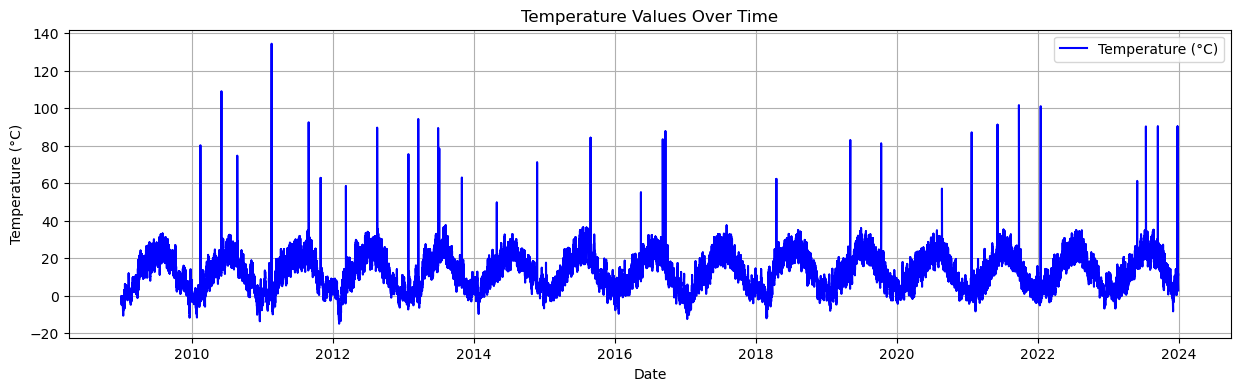

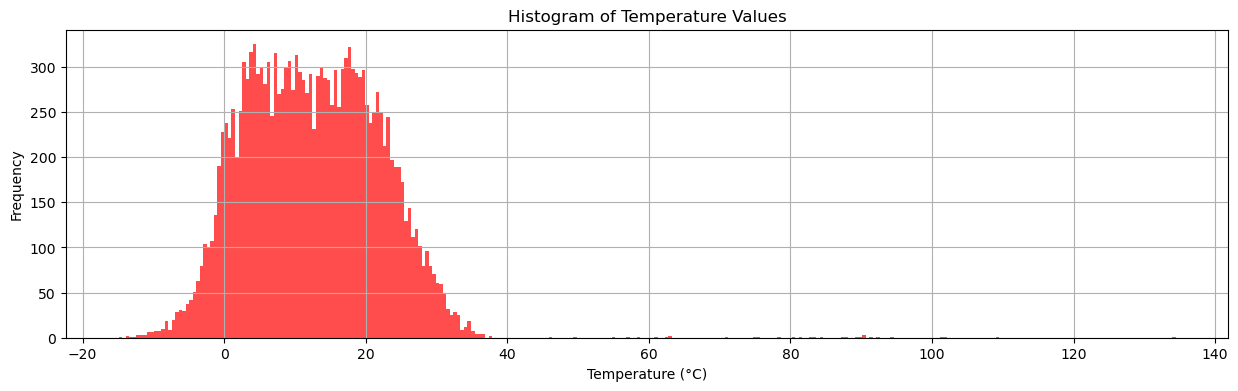

In [149]:
# DO NOT MODIFY OR COPY THIS CELL!!
plot_temp_analysis(weather_data_complete)

In [150]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In the next cell, select a random outlier (e.g. the first) and plot the temperature curve around the outlier.

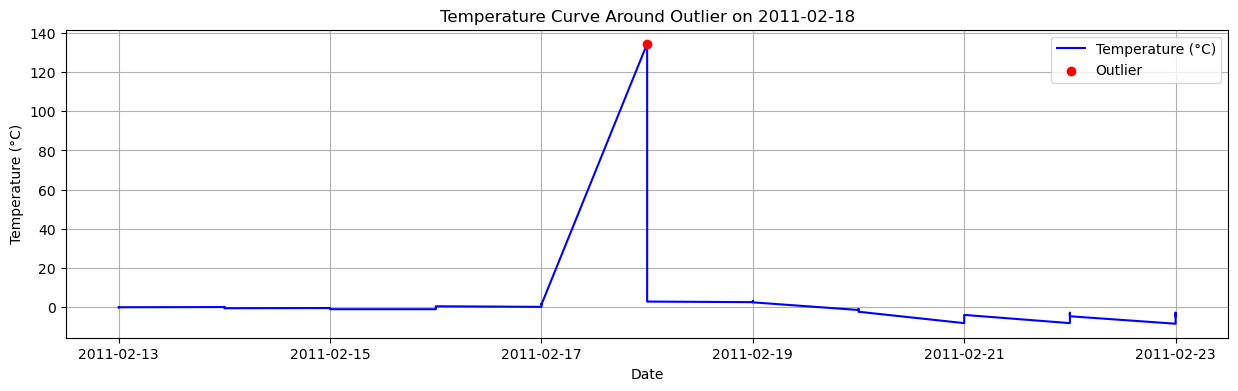

In [151]:
# find outlier (ie. max temp)
outlier_value = weather_data_complete['temp'].max()
outlier_date = weather_data_complete[weather_data_complete['temp'] == outlier_value]['date'].values[0]
outlier_date = pd.to_datetime(outlier_date)

# filter a window of data around the outlier (ie. 5 days before and after)
start_date = outlier_date - pd.Timedelta(days=5)
end_date = outlier_date + pd.Timedelta(days=5)
filtered_data = weather_data_complete[(weather_data_complete['date'] >= start_date) & (weather_data_complete['date'] <= end_date)]

# plot the temperature curve around the outlier
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(filtered_data['date']), filtered_data['temp'], label='Temperature (°C)', color='blue')
plt.scatter(outlier_date, outlier_value, color='red', label='Outlier', zorder=5)
plt.title(f'Temperature Curve Around Outlier on {outlier_date.date()}')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.show()

In [152]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

#### Remove temperature outliers
Implement the below function using the strategy you defined above to get rid of the temperature outliers

In [153]:
def handle_temp_outliers(noisy_data) -> pd.DataFrame:
    """
    Parameters
    --------
    noisy_data: data frame that contains temperature outliers ('temp' column)

    Returns
    --------
    cleaned_data: data frame with temperature outliers removed/handled
    """
    
    # strategy 1) remove statistical outliers using IQR (interquartile range)
    # strategy 2) remove physically impossible measurements
    # - https://www.extremeweatherwatch.com/cities/vienna/highest-temperatures
    # - https://www.extremeweatherwatch.com/cities/vienna/lowest-temperatures
    
    cleaned_data = noisy_data.copy()
    min_temp, max_temp = -20, 40 
    
    Q1 = cleaned_data['temp'].quantile(0.25)
    Q3 = cleaned_data['temp'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(min_temp, Q1 - 1.5 * IQR)
    upper_bound = min(max_temp, Q3 + 1.5 * IQR)
    
    cleaned_data['month'] = cleaned_data.index.month
    cleaned_data['hour'] = cleaned_data.index.hour
    
    def replace_outliers(group):
        median = group['temp'].median()
        group.loc[(group['temp'] < lower_bound) | (group['temp'] > upper_bound), 'temp'] = median
        return group
    
    cleaned_data = cleaned_data.groupby(['month', 'hour']).apply(replace_outliers)
    
    cleaned_data = cleaned_data.drop(columns=['month', 'hour'])
    return cleaned_data

/tmp/ipykernel_217/1017946768.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_data = cleaned_data.groupby(['month', 'hour']).apply(replace_outliers)


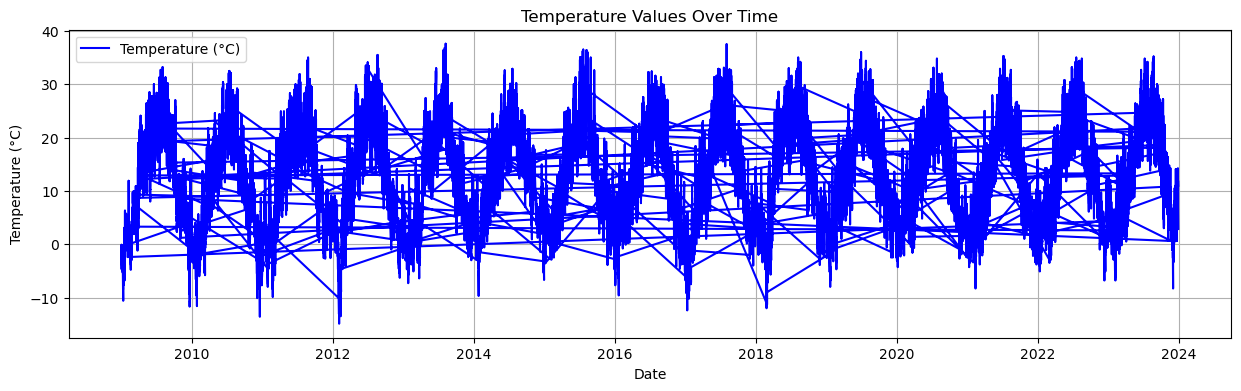

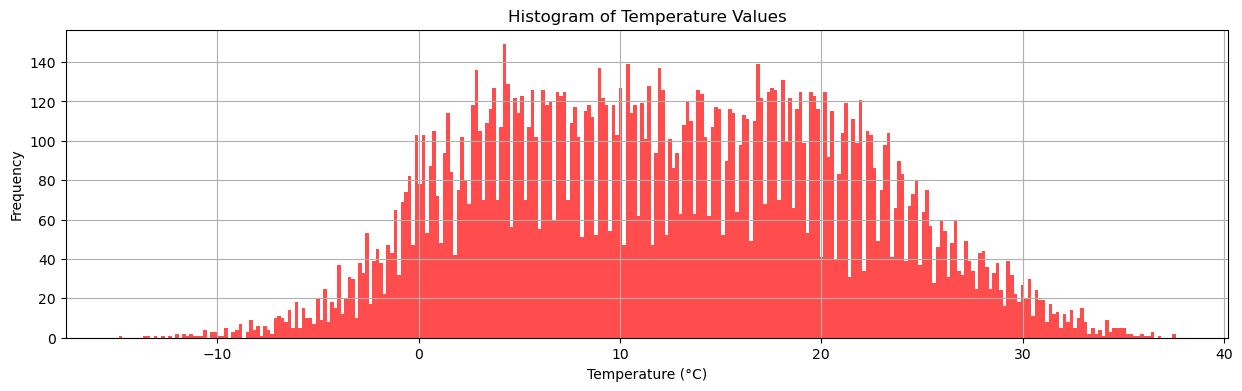

count    16434.000000
mean        12.427562
std          9.001924
min        -14.900000
25%          5.200000
50%         12.200000
75%         19.400000
max         37.600000
Name: temp, dtype: float64


In [154]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_cleaned = handle_temp_outliers(weather_data_complete)
plot_temp_analysis(weather_data_cleaned)
print(weather_data_cleaned['temp'].describe())

In [155]:
# test, DO NOT MODIFY OR COPY THIS CELL!!

# check if new missing values were introduced
assert not weather_data_cleaned.isna().any().any()
# check if outliers were simply dropped
assert weather_data_cleaned.shape == weather_data_complete.shape

In [156]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In [157]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

### 3.2 Wind speed outliers

The second outlier problem was, that in the timespan from early May 2017 until November 2017, the wind sensor was defective: it might have displayed wrong values for winds from NE direction.

Double check if this is true, and if it is, fix the values appropriately.

#### Data inspection

Implement the function below to visualize the problematic wind sensor data.
Complete the function below to check the assumptions for wrong values of windBeauf.
- Plot the wind speed data over the questionable time duration (early May 2017 until November 2017)
- Plot a histogram of the windspeed values to identify outliers
- Check if the assumption regarding the wind direction is true (errors only from NE direction)

Bonus:
- Find out when exactly the sensor started to produce wrong values and when the sensor was fixed!

In [158]:
def analyze_wind_range(df: pd.DataFrame) -> typing.Tuple[int, typing.List[str]]:
    """
    Plot analysis plots for the wind data. Print outputs about relevant data 
    and return the relevant values as indicated.

    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    wind_dir_outliers: list of wind direction string code, for which outliers where found
    num_outliers: number of found outliers

    """

    # timedate given by meteorological station
    start_date = '2017-05-01'
    end_date = '2017-11-30'
    filtered_data = df[(df.index >= start_date) & (df.index <= end_date)]
    
    # plot wind speed data over time
    plt.figure(figsize=(15, 4))
    plt.plot(filtered_data.index, filtered_data['windBeauf'], marker='o', linestyle='-')
    plt.title('Wind Speed Data from May 2017 to November 2017')
    plt.xlabel('Date')
    plt.ylabel('Wind Speed (Beaufort Scale)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # plot histogram of wind speed values
    plt.figure(figsize=(15, 4))
    plt.hist(filtered_data['windBeauf'], bins=range(0, 13), edgecolor='black', alpha=0.7)
    plt.title('Histogram of Wind Speed (Beaufort Scale)')
    plt.xlabel('Wind Speed (Beaufort Scale)')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 13))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # check for outliers in NE direction
    ne_data = filtered_data[filtered_data['windDir'] == 'NE']
    outliers = ne_data[ne_data['windBeauf'] > 8]  # assuming values above 8 are outliers
    num_outliers = len(outliers)
    wind_dir_outliers = ['NE'] if num_outliers > 0 else []  # outlier directions

    # find start and end dates of wrong values
    if num_outliers > 0:
        wrong_start_date = outliers.index.min()
        wrong_end_date = outliers.index.max()
        print(f"wrong values started on: {wrong_start_date}")
        print(f"wrong values ended on: {wrong_end_date}")
    else:
        print("no outliers found for NE direction")

    print(f"number of outliers: {num_outliers}")
    print(f"wind directions with outliers: {wind_dir_outliers}")

    return wind_dir_outliers, num_outliers

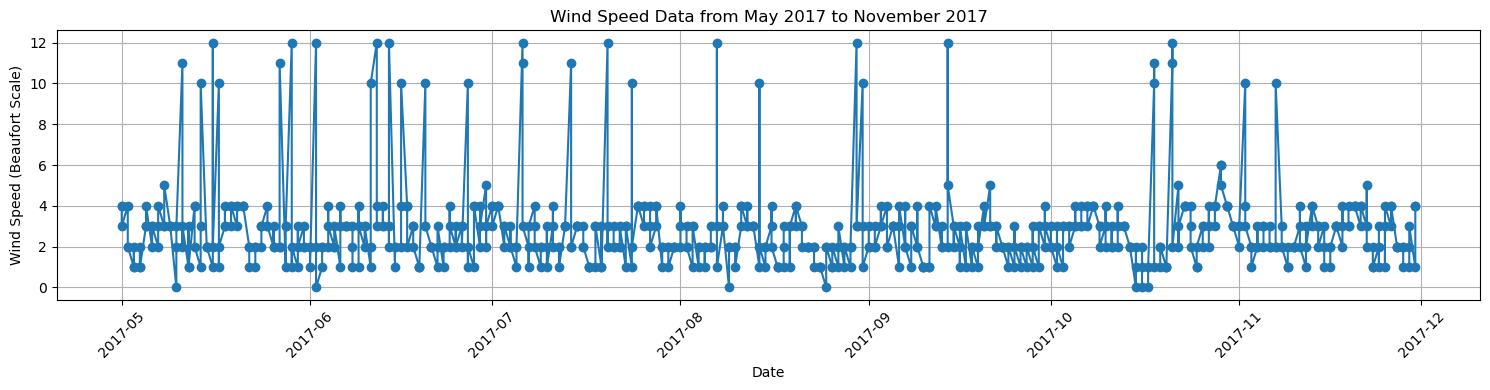

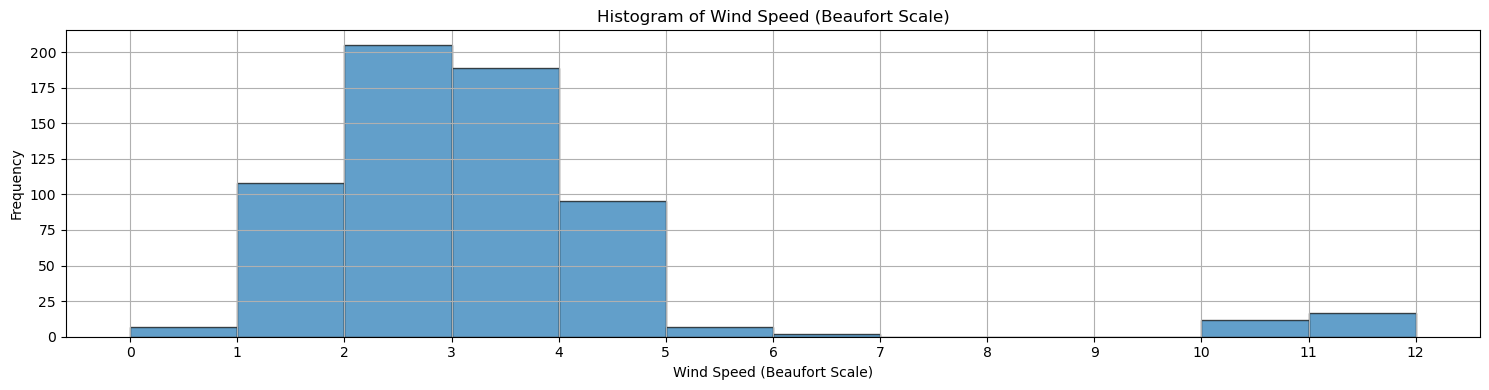

wrong values started on: 2017-05-11 00:00:00
wrong values ended on: 2017-11-07 00:00:00
number of outliers: 29
wind directions with outliers: ['NE']


In [159]:
# DO NOT MODIFY OR COPY THIS CELL!!
wind_dir_outliers, num_outliers = analyze_wind_range(weather_data_complete)

In [160]:
assert 0 < num_outliers < 500, "there should be more than zero but less than 500 outliers!"
assert len(wind_dir_outliers) > 0, "there should be at least one wind direction!"
assert isinstance(wind_dir_outliers[0], str), "the wind direction codes are strings with two characters!"
assert len(wind_dir_outliers[0]) == 2, "the wind direction codes are strings with two characters!"

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

#### Fix wind sensor outliers
Fix the values appropriately. Implement a function that compensates for the problem you found.

In [161]:
def fix_windBeauf_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains potential faulty wind values

    Returns
    -------
    df_ret: data frame with fixed wind values
    """
    df_ret = df.copy()
    
    temp_index = pd.to_datetime(df_ret.index.get_level_values('date')) # complications because of multiindex
    start_date = pd.to_datetime('2017-05-01')
    end_date = pd.to_datetime('2017-11-30')
    mask = (temp_index >= start_date) & (temp_index <= end_date)
    
    ne_mask = (df_ret['windDir'] == 'NE') & (df_ret['windBeauf'] > 8)
    df_ret.loc[mask & ne_mask, 'windBeauf'] = df_ret.loc[mask, 'windBeauf'].median() # impute with median from all directions in the same period

    return df_ret


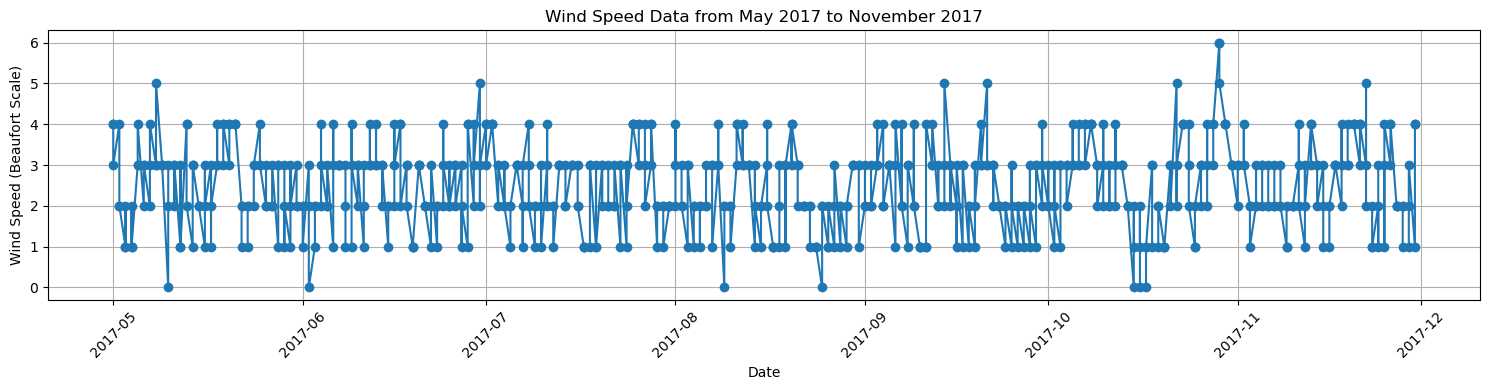

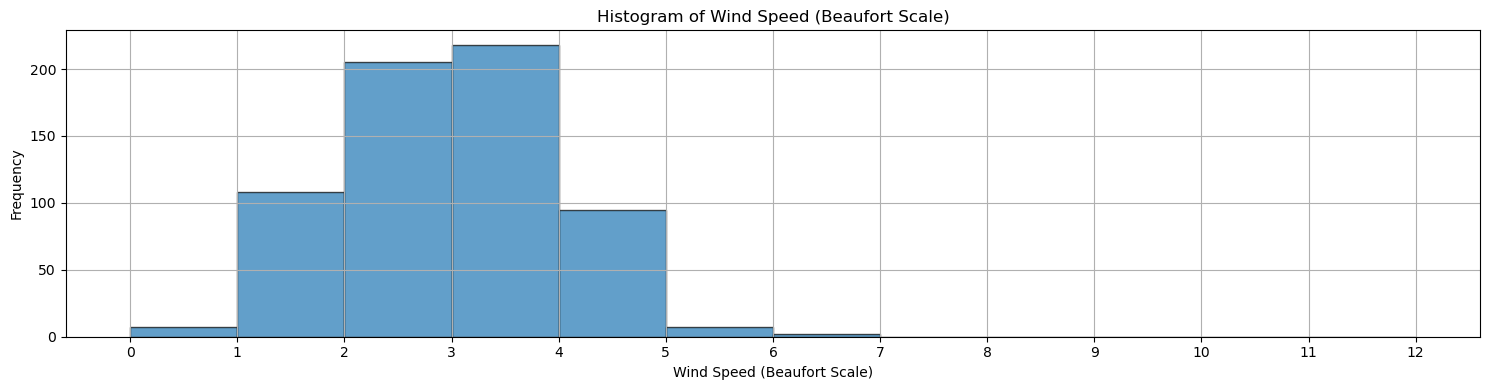

no outliers found for NE direction
number of outliers: 0
wind directions with outliers: []


In [162]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
weather_data_fix_wind = fix_windBeauf_values(weather_data_complete)
wind_dir_outliers_fixed, num_outliers_fixed = analyze_wind_range(weather_data_fix_wind)

In [163]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
print(num_outliers_fixed)
assert num_outliers_fixed == 0, "now no outliers should be found"
assert len(wind_dir_outliers_fixed) == 0, "now no outliers should be found, so no directions!"
assert weather_data_fix_wind.shape == weather_data_complete.shape

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

0


### 3.3 Daily weather data: precipitation

When loading the data, we separated the precipitation data into the `daily_weather_data` dataframe.
This dataframe also has an issues:

- The `precip` column contains some non-numeric values 

#### Data inspection
Check the occurance of the non-numeric values in the precipitation data. You can check the file `data/weather/weather_description_<year>.txt`, which might have additional clues what is going on.

Implement the function below and return a list of the non-numeric values that occur in the `precip` column of `daily_weather_data`. Make sure to only return every unique value once! 

In [164]:
def get_non_numeric_precip_values(df:pd.DataFrame) -> typing.Set[str]:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    non_numeric_values: list of unique non-numeric values. 
    Do not return duplicate values in the list!
    """
    non_numeric_values = set(df['precip'][pd.to_numeric(df['precip'], errors='coerce').isna()])
    return non_numeric_values

In [165]:
# DO NOT MODIFY OR COPY THIS CELL!!
non_numeric_values = get_non_numeric_precip_values(daily_weather_data)
print(f"\nnon-numeric values values: {non_numeric_values}")


non-numeric values values: {'traces'}


In [166]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert isinstance(non_numeric_values, set) , "make sure to return a set, so no duplicate values can be returned!!"
assert len(non_numeric_values) > 0, "there should be some non-numeric values in daily_weather_data!"
assert isinstance(list(non_numeric_values)[0], str), "only return the non-numeric values as strings!"

#### Fix non-numeric values
Replace non-numeric values with some appropriate numerical values and convert the column to a more suitable data type.
To get an idea, what appropriate values might be, check the file `data/weather/weather_description_<year>.txt` and the other numeric values in the `precip` column.

In [167]:
def fix_precip_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    ret_df: data frame with fixed precip values
    """
    ret_df = df.copy()
    ret_df['precip'] = ret_df['precip'].replace('traces', 0.05) # replace 'traces' with 0.05 mm
    ret_df['precip'] = pd.to_numeric(ret_df['precip'], errors='coerce') # coerce to NaN if not numeric
    ret_df['precip'] = ret_df['precip'].fillna(0) # fill NaN with 0
    return ret_df

In [168]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_fixed_precip = fix_precip_values(daily_weather_data)

In [169]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert pd.api.types.is_float_dtype(daily_weather_data_fixed_precip['precip'].dtype), "precip should now be a float column!!"
assert daily_weather_data_fixed_precip.shape == daily_weather_data.shape, "do not remove or add rows!"

### Combining the fixes

In [170]:
# DO NOT MODIFY OR COPY THIS CELL!!
def fix_values_daily(data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = data.copy()
    complete_data = fix_precip_values(complete_data)
    
    return complete_data

   
def handle_outliers(data):
    """ 
    Parameters
    --------
    data: data frame containing outlier values 
    
    Returns
    --------
    complete_data: data frame not containing any outlier values
    """
    complete_data = data.copy()
    complete_data = handle_temp_outliers(complete_data)
    complete_data = fix_windBeauf_values(complete_data)
    
    return complete_data

In [171]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_finished = fix_values_daily(daily_weather_data)
weather_data_finished = handle_outliers(weather_data_complete)

/tmp/ipykernel_217/1017946768.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_data = cleaned_data.groupby(['month', 'hour']).apply(replace_outliers)


In [172]:
weather_data_complete

,date,airPressure,skyCover,temp,hum,windDir,windBeauf
date,,,,,,,
2009-01-01,2009-01-01,999.7,10,-4.5,79,W,2
2009-01-01,2009-01-01,998.8,5,-0.1,71,NW,2
2009-01-01,2009-01-01,1000.7,10,-1.8,72,NW,2
2009-01-02,2009-01-02,999.6,10,-3.0,67,Calm,0
2009-01-02,2009-01-02,998.5,9,-1.3,66,W,2
...,...,...,...,...,...,...,...
2023-12-30,2023-12-30,993.2,4,11.9,58,W,3
2023-12-30,2023-12-30,993.6,0,7.1,78,W,2
2023-12-31,2023-12-31,988.8,10,3.2,96,SE,2


## Task 4: Aggregate values (5 Points)

Aggregate the observations on a daily basis. Return a data frame with a hierarchical index (levels `year`, `month` and `day`) and the following daily aggregations as columns:

- `temp_dailyMin`: minimum of `temp`
- `temp_dailyMax`: max of `temp`
- `temp_dailyMean`: mean of `temp`
- `temp_dailyMedian`: median of `temp`

- `hum_dailyMin`: min of `hum`
- `hum_dailyMax`: max of `hum`
- `hum_dailyMean`: mean of `hum`

- `wind_dailyMean`: mean of `windBeauf`
- `wind_dailyMax`: max of `windBeauf`
- `wind_dailyMin`: min of `windBeauf`

Additionally merge the precipitation values from the `daily_weather_data` dataframe also into the newly created dataframe and aggregate them into the folling cprecipp_wvaluelyMin`: min of `precip`



In [173]:
def aggregate_daily(hourly_data, daily_data):
    hourly_agg = hourly_data.groupby(hourly_data['date']).agg({
        'temp': ['min', 'max', 'mean', 'median'],
        'hum': ['min', 'max', 'mean'],
        'windBeauf': ['min', 'max', 'mean']
    })
    
    # flatten hierarchical column index
    hourly_agg.columns = ['_'.join(col).strip() for col in hourly_agg.columns]
    
    # rename columns to match required format
    hourly_agg.rename(columns={
        'temp_min': 'temp_dailyMin',
        'temp_max': 'temp_dailyMax',
        'temp_mean': 'temp_dailyMean',
        'temp_median': 'temp_dailyMedian',
        'hum_min': 'hum_dailyMin',
        'hum_max': 'hum_dailyMax',
        'hum_mean': 'hum_dailyMean',
        'windBeauf_min': 'wind_dailyMin',
        'windBeauf_max': 'wind_dailyMax',
        'windBeauf_mean': 'wind_dailyMean'
    }, inplace=True)
    
    # convert index to datetime
    hourly_agg.index = pd.to_datetime(hourly_agg.index)
    
    # create multiindex again
    hourly_agg.index = pd.MultiIndex.from_tuples(
        [(d.year, d.month, d.day) for d in hourly_agg.index],
        names=['year', 'month', 'day']
    )
    
    # aggregate daily precipitation data
    daily_precip = daily_data['precip'].groupby(level=['year', 'month', 'day']).min().rename('precip_dailyMin')
    
    # merge hourly aggregations with daily precipitation
    result = hourly_agg.merge(daily_precip, left_index=True, right_index=True, how='left')
    
    return result

In [174]:
agg_daily_data = aggregate_daily(weather_data_finished, daily_weather_data_finished)

len(agg_daily_data.columns)

11

In [175]:
# DO NOT MODIFY OR COPY THIS CELL!!
agg_daily_data =  aggregate_daily(weather_data_finished, daily_weather_data_finished)
display(agg_daily_data)
assert len(agg_daily_data.columns) >= 11

temp_dailyMin  temp_dailyMax  temp_dailyMean  \
year month day                                                 
2009 1     1             -4.5           -0.1       -2.133333   
           2             -3.0           -1.3       -2.000000   
           3             -4.8           -1.7       -3.466667   
           4             -3.8           -0.2       -1.500000   
           5             -1.3           -0.6       -0.866667   
...                       ...            ...             ...   
2023 12    27             3.0            8.2        5.933333   
           28             2.8            4.4        3.700000   
           29             8.6           14.2       11.533333   
           30             7.1           11.9        9.933333   
           31             2.9            3.7        3.266667   

                temp_dailyMedian  hum_dailyMin  hum_dailyMax  hum_dailyMean  \
year month day                                                                
2009 1     1                -1.8            71            79      74.000000   
           2                -1.7            66            68      67.000000   
           3                -3.9            70            83      74.333333   
           4                -0.5            62            75      66.666667   
           5                -0.7            64            80      73.333333   
...                          ...           ...           ...            ...   
2023 12    27                6.6            59            82      69.333333   
           28                3.9            84            96      91.666667   
           29               11.8            44            66      55.000000   
           30               10.8            58            78      66.333333   
           31                3.2            88            96      91.000000   

                wind_dailyMin  wind_dailyMax  wind_dailyMean  precip_dailyMin  
year month day                                                                 
2009 1     1                2              2        2.000000             0.00  
           2                0              3        1.666667             0.05  
           3                2              2        2.000000             0.00  
           4                3              4        3.666667             0.05  
           5                2              4        3.000000             0.05  
...                       ...            ...             ...              ...  
2023 12    27               2              2        2.000000             0.00  
           28               1              2        1.333333             0.00  
           29               2              4        3.000000             0.00  
           30               2              3        2.666667             0.00  
           31               0              2        1.000000             5.40  

[5478 rows x 11 columns]

In [176]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert len(agg_daily_data.columns) >= 11, "according to the instructions, the dataframe should have >= 13 columns"
assert len(agg_daily_data.index.levels) == 3, "according to the instructions, the dataframe should have a multi-index with 2 levels"

In [177]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

## Task 5: Merge Traffic and weather datasets (5 Points)

Merge the `agg_daily_data` and `data_traffic` datasets.
Both dataframes should now be on a daily index. 
Beware that both datasets contain rows that do not appear in the other dataset.

In [178]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Neither of the tables contain missing data

print(f"traffic data, missing data (should be 0): \n{data_traffic.isna().sum()}")
print(f"weather data, missing data (should be 0): \n{agg_daily_data.isna().sum()}")

assert not data_traffic.isna().any().any(), "we should have eliminated all missing values!!"
assert not agg_daily_data.isna().any().any(), "we should have eliminated all missing values!!"

traffic data, missing data (should be 0): 
disruption    0
bus           0
subway        0
tram          0
duration      0
dtype: int64
weather data, missing data (should be 0): 
temp_dailyMin       0
temp_dailyMax       0
temp_dailyMean      0
temp_dailyMedian    0
hum_dailyMin        0
hum_dailyMax        0
hum_dailyMean       0
wind_dailyMin       0
wind_dailyMax       0
wind_dailyMean      0
precip_dailyMin     0
dtype: int64


In [179]:
# use this cell for experimentation / analysis for merging data

In [180]:
def merge_data(weather_df, traffic_df):
    """ 
    Parameters
    --------
    weather_df: daily weather data frame
    traffic_df: traffic data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both daily weather observations and traffic incidents
    """
    
    # assert multiindex works
    assert isinstance(weather_df.index, pd.MultiIndex), "weather_df should have a MultiIndex"
    assert isinstance(traffic_df.index, pd.MultiIndex), "traffic_df should have a MultiIndex"
    weather_df.index.names = ['year', 'month', 'day']
    traffic_df.index.names = ['year', 'month', 'day']

    # outer join
    merged_data = pd.merge(weather_df, traffic_df, left_index=True, right_index=True, how='outer')

    # deal with missing vals through outer join
    merged_data['disruption'] = merged_data['disruption'].fillna('unknown')
    boolean_columns = ['bus', 'subway', 'tram']
    merged_data[boolean_columns] = merged_data[boolean_columns].fillna(False)
    merged_data['duration'] = merged_data['duration'].fillna(pd.Timedelta(0))
    assert not merged_data.isna().any().any(), "every column should be filled!"

    return merged_data

In [181]:
# DO NOT MODIFY OR COPY THIS CELL!!
data_merged = merge_data(agg_daily_data, data_traffic)
data_merged

/tmp/ipykernel_217/4149537295.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data[boolean_columns] = merged_data[boolean_columns].fillna(False)


temp_dailyMin  temp_dailyMax  temp_dailyMean  \
year month day                                                 
2009 1     1             -4.5           -0.1       -2.133333   
           2             -3.0           -1.3       -2.000000   
           3             -4.8           -1.7       -3.466667   
           4             -3.8           -0.2       -1.500000   
           5             -1.3           -0.6       -0.866667   
...                       ...            ...             ...   
2023 12    27             3.0            8.2        5.933333   
           28             2.8            4.4        3.700000   
           29             8.6           14.2       11.533333   
           30             7.1           11.9        9.933333   
           31             2.9            3.7        3.266667   

                temp_dailyMedian  hum_dailyMin  hum_dailyMax  hum_dailyMean  \
year month day                                                                
2009 1     1                -1.8            71            79      74.000000   
           2                -1.7            66            68      67.000000   
           3                -3.9            70            83      74.333333   
           4                -0.5            62            75      66.666667   
           5                -0.7            64            80      73.333333   
...                          ...           ...           ...            ...   
2023 12    27                6.6            59            82      69.333333   
           28                3.9            84            96      91.666667   
           29               11.8            44            66      55.000000   
           30               10.8            58            78      66.333333   
           31                3.2            88            96      91.000000   

                wind_dailyMin  wind_dailyMax  wind_dailyMean  precip_dailyMin  \
year month day                                                                  
2009 1     1                2              2        2.000000             0.00   
           2                0              3        1.666667             0.05   
           3                2              2        2.000000             0.00   
           4                3              4        3.666667             0.05   
           5                2              4        3.000000             0.05   
...                       ...            ...             ...              ...   
2023 12    27               2              2        2.000000             0.00   
           28               1              2        1.333333             0.00   
           29               2              4        3.000000             0.00   
           30               2              3        2.666667             0.00   
           31               0              2        1.000000             5.40   

               disruption    bus  subway   tram duration  
year month day                                            
2009 1     1      unknown  False   False  False   0 days  
           2      unknown  False   False  False   0 days  
           3      unknown  False   False  False   0 days  
           4      unknown  False   False  False   0 days  
           5      unknown  False   False  False   0 days  
...                   ...    ...     ...    ...      ...  
2023 12    27     unknown  False   False  False   0 days  
           28     unknown  False   False  False   0 days  
           29     unknown  False   False  False   0 days  
           30     unknown  False   False  False   0 days  
           31     unknown  False   False  False   0 days  

[96593 rows x 16 columns]

In [182]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
print(data_merged.shape)
assert data_merged.shape[0] > 90000, "there should be more than 90.000 rows in the merged dataset"
assert data_merged.shape[1] >= 16, "5 column for traffic, 11 feature columns from weather data"


(96593, 16)


## Store processed data for Tasks 6-8

Here we export the prepared dataset for usage in the notebook B.
If you encounter problems with the first five tasks, you can load a pickled `DataFrame` containing already merged and preprocessed weather and traffic datasets. You can use this data to complete tasks 6-8 in notebook B. 

In [183]:
with open(os.path.join(os.environ["HOME"],"data_processed.pickle"),"wb") as fp:
    pickle.dump(data_merged, fp)  